In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from matplotlib import cm


In [6]:
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/prematurity_labels_true_classes.csv"
base_path   = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"

In [7]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [8]:
thresholds  = ["<28","28-32","32-37"]
threshold = thresholds[1]
region = "STs_right"
#region = "FCMpost-SpC_right"

In [9]:
embedding_file = None
for file in os.listdir(base_path):
    if file.startswith(region) and file.endswith(".csv"):
        embedding_file = file
        break
if embedding_file is None:
    raise FileNotFoundError(f"No embedding file found for region: {region}")

emb_path = os.path.join(base_path, embedding_file)
emb_df = pd.read_csv(emb_path)
emb_df['ID_clean'] = (
    emb_df['ID'].astype(str)
    .str.replace(r"^sub-", "", regex=True)
    .str.replace("_", "", regex=False)
)

df = emb_df.merge(
    labels_df,
    left_on='ID_clean', right_on='src_subject_id', how='inner'
)
# statistics of prematurity groups
print(df['prem_class'].value_counts())
# percentages per class
print(df['prem_class'].value_counts(normalize=True) * 100)
#df = df[df['prem_class'].isin([threshold, ">=37"])].copy()
df['y'] = (df['prem_class'].isin(thresholds).astype(int))
print(df['y'].value_counts())

X = df.filter(regex=r'^dim').values
y = df[['src_subject_id','y']]

prem_class
>=37     8646
32-37    1215
28-32      86
<28        38
Name: count, dtype: int64
prem_class
>=37     86.589885
32-37    12.168252
28-32     0.861292
<28       0.380571
Name: proportion, dtype: float64
y
0    8646
1    1339
Name: count, dtype: int64


In [10]:
# Ensure the labels and embeddings are aligned by printing the first few rows
print("First few rows of the merged DataFrame:")
print(df[['ID_clean', 'src_subject_id','prem_class', 'y']].head())



First few rows of the merged DataFrame:
          ID_clean   src_subject_id prem_class  y
0  NDARINV003RTV85  NDARINV003RTV85       >=37  0
1  NDARINV007W6H7B  NDARINV007W6H7B       >=37  0
2  NDARINV00BD7VDC  NDARINV00BD7VDC       >=37  0
3  NDARINV00HEV6HB  NDARINV00HEV6HB       >=37  0
4  NDARINV00J52GPG  NDARINV00J52GPG       >=37  0


In [11]:
# KMeans and centroids
n_clusters = 40
n_target   = 250

kmeans   = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
centroids = kmeans.cluster_centers_
labels0   = kmeans.labels_

# Build truncated and overlappable clusters
new_assign = {c: [] for c in range(n_clusters)}

# keep the 250 closest within each original cluster
for c in range(n_clusters):
    idx_c = np.where(labels0 == c)[0]
    dists = np.linalg.norm(X[idx_c] - centroids[c], axis=1)
    order = np.argsort(dists)
    new_assign[c] = list(idx_c[order[:n_target]])

# fill to exactly 250 by grabbing next-closest from entire dataset
for c in range(n_clusters):
    current = set(new_assign[c])
    deficit = n_target - len(current)
    if deficit > 0:
        # compute distances from all points to centroid c
        dists_all = np.linalg.norm(X - centroids[c], axis=1)
        order_all = np.argsort(dists_all)
        # pick the closest that aren’t already in this cluster
        to_add = []
        for idx in order_all:
            if idx not in current:
                to_add.append(idx)
                if len(to_add) == deficit:
                    break
        new_assign[c].extend(to_add)


for c in range(n_clusters):
    assert len(new_assign[c]) == n_target, f"Cluster {c} size = {len(new_assign[c])}"

# Export overlapping clusters to CSV
rows = []
for c, members in new_assign.items():
    for idx in members:
        rows.append({
            'cluster_fixed250': c,
            'src_subject_id':   df.iloc[idx]['src_subject_id']
        })


out_df = pd.DataFrame(rows)



## Cluster identification among all preterm subjects in the ABCD cohort

Cluster 0: 35 preterms / 250 (14.00%)
Cluster 1: 25 preterms / 250 (10.00%)
Cluster 2: 36 preterms / 250 (14.40%)
Cluster 3: 27 preterms / 250 (10.80%)
Cluster 4: 36 preterms / 250 (14.40%)
Cluster 5: 21 preterms / 250 (8.40%)
Cluster 6: 25 preterms / 250 (10.00%)
Cluster 7: 35 preterms / 250 (14.00%)
Cluster 8: 37 preterms / 250 (14.80%)
Cluster 9: 31 preterms / 250 (12.40%)
Cluster 10: 38 preterms / 250 (15.20%)
Cluster 11: 20 preterms / 250 (8.00%)
Cluster 12: 43 preterms / 250 (17.20%)
Cluster 13: 17 preterms / 250 (6.80%)
Cluster 14: 28 preterms / 250 (11.20%)
Cluster 15: 23 preterms / 250 (9.20%)
Cluster 16: 26 preterms / 250 (10.40%)
Cluster 17: 27 preterms / 250 (10.80%)
Cluster 18: 49 preterms / 250 (19.60%)
Cluster 19: 36 preterms / 250 (14.40%)
Cluster 20: 22 preterms / 250 (8.80%)
Cluster 21: 37 preterms / 250 (14.80%)
Cluster 22: 34 preterms / 250 (13.60%)
Cluster 23: 29 preterms / 250 (11.60%)
Cluster 24: 41 preterms / 250 (16.40%)
Cluster 25: 47 preterms / 250 (18.80%)
C

/tmp/ipykernel_1639672/1454060757.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


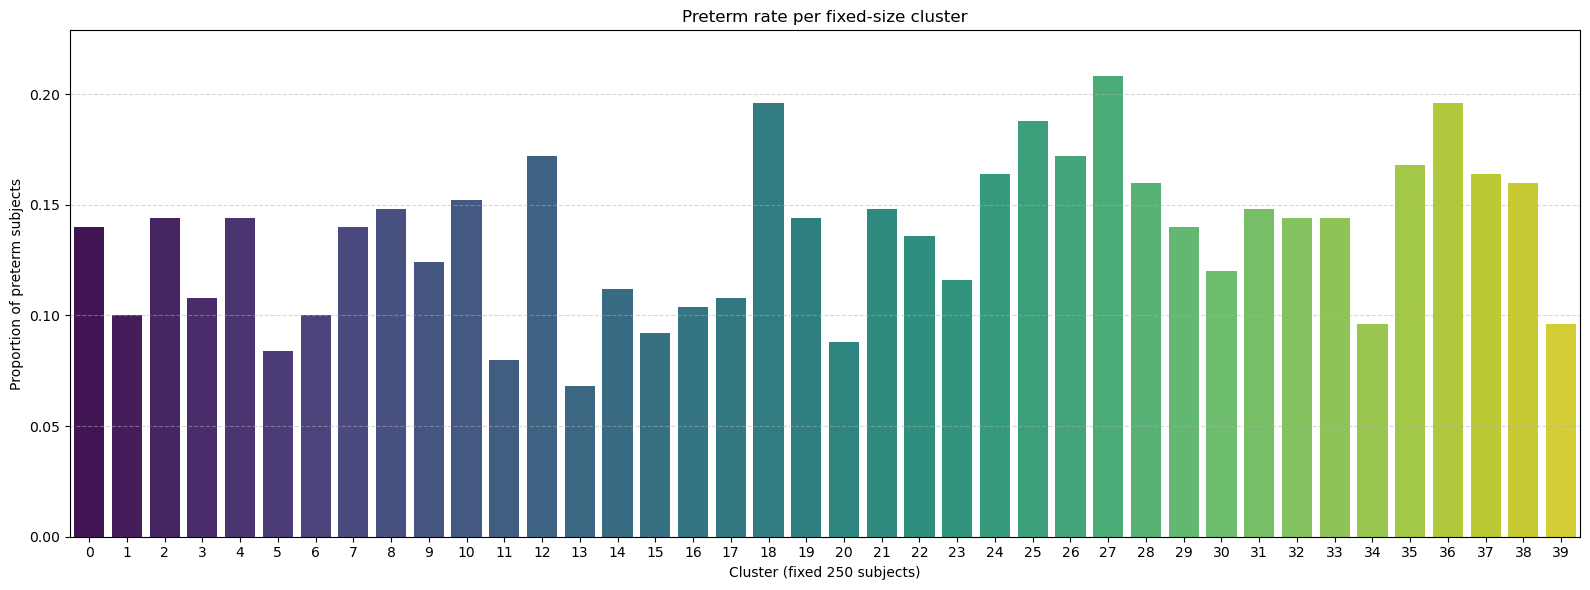

In [12]:
clusters_df = out_df.merge(
    df[['src_subject_id','y']],
    on='src_subject_id',
    how='left'
)

# Compute the stats per cluster
cluster_stats = (
    clusters_df
    .groupby('cluster_fixed250')['y']
    .agg(['count','sum'])                     # count = 250, sum = n_preterms
    .rename(columns={'count':'n_subjects',
                     'sum':'n_preterms'})
)
cluster_stats['preterm_rate'] = (
    cluster_stats['n_preterms'] / cluster_stats['n_subjects']
)

# Quick overview of the stats
for c in cluster_stats.index:
    rate = cluster_stats.loc[c,'preterm_rate']
    print(f"Cluster {c}: {cluster_stats.loc[c,'n_preterms']} preterms / "
          f"{cluster_stats.loc[c,'n_subjects']} ({rate:.2%})")

# Barplot 
plt.figure(figsize=(16,6))
sns.barplot(
    x=cluster_stats.index,
    y=cluster_stats['preterm_rate'],
    palette='viridis'
)
plt.ylabel("Proportion of preterm subjects")
plt.xlabel("Cluster (fixed 250 subjects)")
plt.title("Preterm rate per fixed‑size cluster")
plt.ylim(0, cluster_stats['preterm_rate'].max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
# Compute prematurity rate per fixed cluster
preterm_rates = (
    clusters_df
    .groupby('cluster_fixed250')['y']
    .mean()
    .sort_values(ascending=False)
)

# Rank clusters by descending prematurity rate
ranked_clusters = {
    cluster_id: rank 
    for rank, cluster_id in enumerate(preterm_rates.index)
}

# Add a new column 'cluster_ranked'
clusters_df['cluster_ranked'] = clusters_df['cluster_fixed250'].map(ranked_clusters)

# Sort DataFrame by that rank (so that cluster 0 is the one with highest preterm rate)
clusters_df = clusters_df.sort_values(by=['cluster_ranked', 'cluster_fixed250'])

# Save to CSV
#clusters_df.to_csv("/neurospin/dico/rmenasria/Runs/03_main/Output/final/clustering/clusters_fixed250_overlapping_ranked_STS_right.csv", index=False)


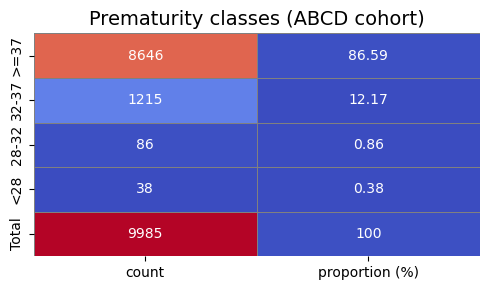

In [14]:
# for the report 

# Data
counts = pd.Series({
    ">=37": 8646,
    "32-37": 1215,
    "28-32": 86,
    "<28": 38
}, name="count")

proportions = counts / counts.sum() * 100
proportions.name = "proportion (%)"

# DataFrame combiné
df = pd.concat([counts, proportions.round(2)], axis=1)

# Ajouter le total
df.loc["Total"] = [counts.sum(), proportions.sum()]

# Reset index pour affichage clair
df = df.reset_index().rename(columns={"index": "Prematurity class"})

# Plot heatmap style (verticale)
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(
    df.set_index("Prematurity class"),
    annot=True, fmt="g", cmap="coolwarm", cbar=False,
    linewidths=.5, linecolor="gray", ax=ax
)

ax.set_ylabel("")
ax.set_title("Prematurity classes (ABCD cohort)", fontsize=14)

plt.tight_layout()
plt.show()




In [15]:
from scipy.stats import binomtest, chi2_contingency

# 1. Test binomial sur le cluster le plus "préterm"
# proportion globale
p_global = clusters_df['y'].mean()
# choisir par exemple le cluster avec max preterm_rate
c_top = cluster_stats['preterm_rate'].idxmax()
n = cluster_stats.loc[c_top, 'n_subjects']
k = cluster_stats.loc[c_top, 'n_preterms']

res_binom = binomtest(k, n, p=p_global, alternative='greater')
print(f"[Binomial test] Cluster {c_top}: k={k}, n={n}, p_global={p_global:.3f}, p-value={res_binom.pvalue:.3e}")

# 2. Test chi² sur toute la table clusters x préma
contingency = pd.crosstab(clusters_df['cluster_fixed250'], clusters_df['y'])
chi2, pval, dof, expected = chi2_contingency(contingency)
print(f"[Chi² test] Chi2={chi2:.2f}, dof={dof}, p-value={pval:.3e}")


[Binomial test] Cluster 27: k=52, n=250, p_global=0.135, p-value=1.011e-03
[Chi² test] Chi2=100.22, dof=39, p-value=2.730e-07


In [17]:
from scipy.stats import binomtest, chi2_contingency
import numpy as np

# proportion globale
p_global = clusters_df['y'].mean()
n_clusters = cluster_stats.shape[0]

# --- 1. Tests binomiaux pour tous les clusters ---
results = []
for c, row in cluster_stats.iterrows():
    n = int(row['n_subjects'])   # cast en int
    k = int(row['n_preterms'])   # cast en int
    res = binomtest(k, n, p=p_global, alternative='greater')
    results.append((c, n, k, row['preterm_rate'], res.pvalue))

results_df = pd.DataFrame(results, columns=["cluster","n_total","n_preterm","rate","pval"])

# Correction Bonferroni
results_df["pval_bonf"] = np.minimum(results_df["pval"] * 2, 1.0)
results_df["signif"] = results_df["pval_bonf"] < 0.05

# --- 2. Chi² global ---
contingency = pd.crosstab(clusters_df['cluster_fixed250'], clusters_df['y'])
chi2, pval_chi2, dof, expected = chi2_contingency(contingency)
print(f"[Chi² test global] Chi2={chi2:.2f}, dof={dof}, p-value={pval_chi2:.3e}")

# --- 3. Extraire min et max pour rapport ---
c_max = results_df.loc[results_df['rate'].idxmax()]
c_min = results_df.loc[results_df['rate'].idxmin()]

summary = results_df.loc[[c_max.name, c_min.name],
                         ["cluster","n_total","n_preterm","rate","pval","pval_bonf","signif"]]

print("\nClusters extrêmes :")
print(summary.to_string(index=False))


[Chi² test global] Chi2=100.22, dof=39, p-value=2.730e-07

Clusters extrêmes :
 cluster  n_total  n_preterm  rate     pval  pval_bonf  signif
      27      250         52 0.208 0.001011   0.040432    True
      13      250         17 0.068 0.999756   1.000000   False


In [18]:
# Tests ciblés uniquement sur les clusters extrêmes (max et min) + Bonferroni pour m=2
from scipy.stats import binomtest
import numpy as np
import pandas as pd

p_global = clusters_df['y'].mean()

# repérer extrêmes
c_max = cluster_stats['preterm_rate'].idxmax()
c_min = cluster_stats['preterm_rate'].idxmin()

rows = []
for c, alt in [(c_max, 'greater'), (c_min, 'less')]:
    n = int(cluster_stats.loc[c, 'n_subjects'])
    k = int(cluster_stats.loc[c, 'n_preterms'])
    rate = cluster_stats.loc[c, 'preterm_rate']
    p_raw = binomtest(k, n, p=p_global, alternative=alt).pvalue
    rows.append({"cluster": c, "n_total": n, "n_preterm": k, "rate": rate, "pval": p_raw})

res2 = pd.DataFrame(rows).sort_values("rate", ascending=False)
res2["pval_bonf"] = np.minimum(res2["pval"] * 2, 1.0)  # Bonferroni avec m=2
res2["signif_0.05"] = res2["pval_bonf"] < 0.05

print("[Binomial ciblé extrêmes] (Bonferroni m=2, max=‘greater’, min=‘less’)")
print(res2.to_string(index=False, formatters={"rate": "{:.3f}".format, "pval":"{:.3e}".format, "pval_bonf":"{:.3e}".format}))


[Binomial ciblé extrêmes] (Bonferroni m=2, max=‘greater’, min=‘less’)
 cluster  n_total  n_preterm  rate      pval pval_bonf  signif_0.05
      27      250         52 0.208 1.011e-03 2.022e-03         True
      13      250         17 0.068 5.515e-04 1.103e-03         True
